In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

More leaky integrate-and-fire (LIF) neuron models available: `Synaptic` and `Alpha`

# 1. Synaptic Conductance-based LIF Neuron Model

$$ \alpha = e^{-\Delta t/\tau_{\rm syn}}$$
$$I_{\rm syn}[t+1]=\underbrace{\alpha I_{\rm syn}[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input}$$
$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{I_{\rm syn}[t+1]}_\text{input} - \underbrace{R[t]}_\text{reset}$$

Each spike contributes a shifted exponential decay to the synaptic current $I_{\rm syn}$, which are all summed together. This current is then integrated by the passive membrane equation generating output spikes.

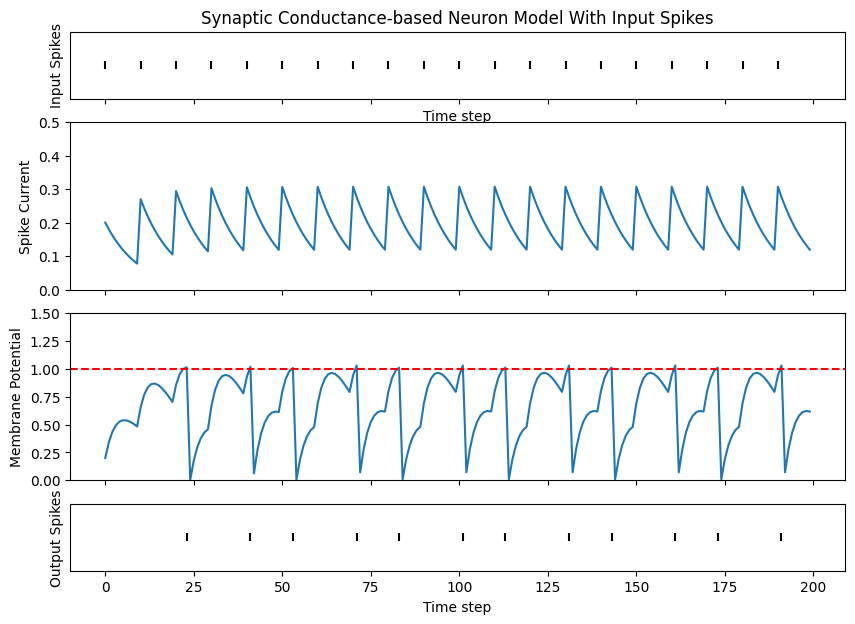

In [20]:
def plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec, title=""):

    fig, ax = plt.subplots(4, 1, figsize=(10, 7), sharex=True, gridspec_kw = {'height_ratios': [0.4, 1, 1, 0.4]})

    splt.raster(spk_in, ax[0], c="black", marker="|")
    ax[0].set_ylabel("Input Spikes")
    ax[0].set_yticks([])    
    ax[0].set_xlabel("Time step")
    ax[0].set_title(title)

    ax[1].plot(syn_rec)
    ax[1].set_ylim([0, 0.5])
    ax[1].set_ylabel("Spike Current")

    ax[2].plot(mem_rec)
    ax[2].set_ylim([0, 1.5])
    ax[2].axhline(1.0, color="red", linestyle="--")
    ax[2].set_ylabel("Membrane Potential")

    splt.raster(spk_rec, ax[3], c="black", marker="|")
    ax[3].set_ylabel("Output Spikes")
    ax[3].set_yticks([])
    ax[3].set_xlabel("Time step")

    plt.show()

# Temporal dynamics
alpha = 0.9
beta = 0.8
num_steps = 200

# Initialize 2nd-order LIF neuron
lif1 = snn.Synaptic(alpha=alpha, beta=beta)

# Periodic spiking input, spk_in = 0.2 V
w = 0.2
spk_period = torch.cat((torch.ones(1)*w, torch.zeros(9)), 0)
spk_in = spk_period.repeat(20)

# Initialize hidden states and output
syn, mem = lif1.init_synaptic()
spk_out = torch.zeros(1)
syn_rec = []
mem_rec = []
spk_rec = []

# Simulate neurons
for step in range(num_steps):
  spk_out, syn, mem = lif1(spk_in[step], syn, mem)
  spk_rec.append(spk_out)
  syn_rec.append(syn)
  mem_rec.append(mem)

# convert lists to tensors
spk_rec = torch.stack(spk_rec)
syn_rec = torch.stack(syn_rec)
mem_rec = torch.stack(mem_rec)

plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec,
                     "Synaptic Conductance-based Neuron Model With Input Spikes")

# 2. Alpha Neuron Model (Hacked Spike Response Model)

$$U_{\rm mem}(t) = \sum_i W(\epsilon * S_{\rm in})(t)$$

where the incoming spikes $S_{\rm in}$ are convolved with a spike response kernel $\epsilon( \cdot )$. The spike response is scaled by a synaptic weight, $W$.

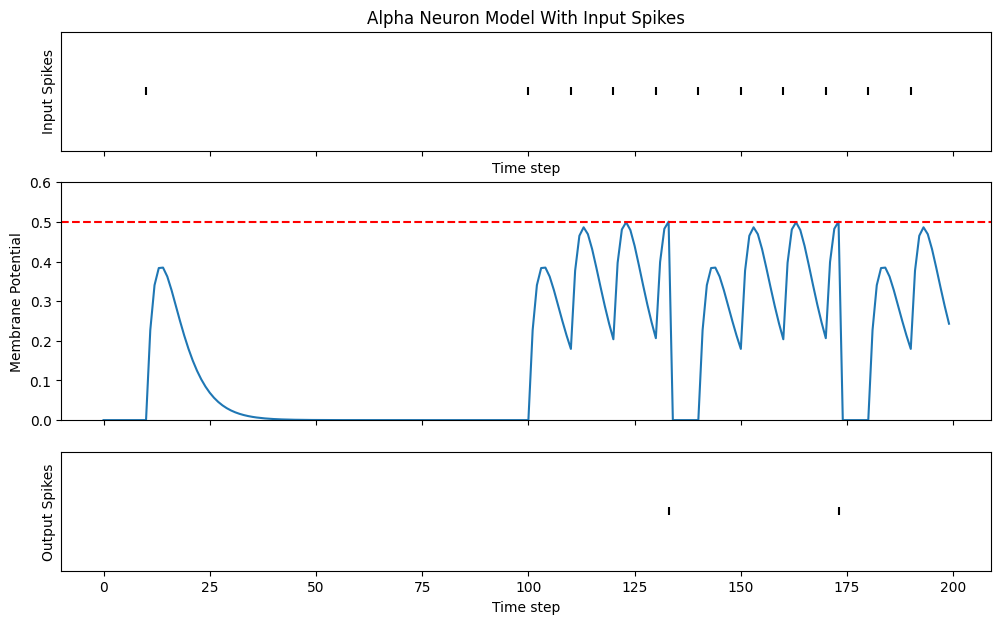

In [26]:
def plot_spk_mem_spk(spk_in, mem_rec, spk_rec, title=""):

    fig, ax = plt.subplots(3, 1, figsize=(12, 7), sharex=True, gridspec_kw = {'height_ratios': [0.5, 1, 0.5]})

    splt.raster(spk_in, ax[0], c="black", marker="|")
    ax[0].set_ylabel("Input Spikes")
    ax[0].set_yticks([])    
    ax[0].set_xlabel("Time step")
    ax[0].set_title(title)

    ax[1].plot(mem_rec)
    ax[1].set_ylim([0, 0.6])
    ax[1].axhline(0.5, color="red", linestyle="--")
    ax[1].set_ylabel("Membrane Potential")

    splt.raster(spk_rec, ax[2], c="black", marker="|")
    ax[2].set_ylabel("Output Spikes")
    ax[2].set_yticks([])
    ax[2].set_xlabel("Time step")

    plt.show()

alpha = 0.8
beta = 0.7

# initialize neuron
lif2 = snn.Alpha(alpha=alpha, beta=beta, threshold=0.5)

# input spike: initial spike, and then period spiking
w = 0.85
spk_in = (torch.cat((torch.zeros(10), torch.ones(1), torch.zeros(89),
                     (torch.cat((torch.ones(1), torch.zeros(9)),0).repeat(10))), 0) * w).unsqueeze(1)

# initialize parameters
syn_exc, syn_inh, mem = lif2.init_alpha()
mem_rec = []
spk_rec = []

# run simulation
for step in range(num_steps):
  spk_out, syn_exc, syn_inh, mem = lif2(spk_in[step], syn_exc, syn_inh, mem)
  mem_rec.append(mem.squeeze(0))
  spk_rec.append(spk_out.squeeze(0))

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_spk_mem_spk(spk_in, mem_rec, spk_rec, "Alpha Neuron Model With Input Spikes")